In [18]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')

In [2]:
import matplotlib
matplotlib.use('Agg')
sns.set(rc={'text.usetex' : True})

In [34]:
%matplotlib inline

In [3]:
from sklearn import preprocessing

from glob import glob
from os.path import join

In [4]:
from glob import glob

In [5]:
from os import rename

In [6]:
import matplotlib as mpl

In [17]:
mpl.rcParams['font.size']

12.0

# Paths

In [20]:
DATA = '/Users/rdora/breast_cancer/'
FIG = '/Users/rdora/Dropbox/inmegen/breast_cancer/article/figures/'

# Normalize

We are going to normalize the MI values to be able to compare between healthy and cancer.

In [89]:
scaler = preprocessing.MaxAbsScaler()

In [73]:
path = join(DATA, 'basal')
for cutoff in range(-1, 101):
    file_name = join(path, 'gene-range_{}.csv'.format(cutoff))
    data = np.genfromtxt(file_name, dtype='unicode', delimiter=',')
    if data.shape[1] == 4:
        data = data[:, 1:]
        np.savetxt(file_name, data, fmt='%s', delimiter=',')

In [114]:
tissues = ["healthy",
          "luma",
          "lumb",
          "her2",
          "basal"]
dfs = []
for tissue in tissues:
    print(tissue)
    path = join(DATA, tissue)
    mis = []
    cutoffs = []
    for cutoff in range(-1, 101):
        file_name = join(path, 'gene-range_{}.csv'.format(cutoff))
        data = np.genfromtxt(file_name, dtype='unicode', delimiter=',')
        mi = data[1:, 1].astype('float')
        mis.append(mi)
        cutoffs.extend([cutoff for i in range(mi.shape[0])])
    mi = np.concatenate(mis)
    mi = mi.reshape(mi.shape[0], 1)
    mi_scaled = scaler.fit_transform(mi)
    df_scaled = pd.DataFrame(mi_scaled, columns=['mi'])
    df_scaled['cutoff'] = cutoffs
    df_scaled['tissue'] = tissue
    dfs.append(df_scaled)
df = pd.concat(dfs, axis=0)

healthy
luma
lumb
her2
basal


# Cis Ratio

In this part we explore the _cis_ ratio of each co-expression layer in five different tissues.

In [39]:
# E. value was computed with uniform probability
# for all gene-pairs.
exp_val = 0.05

In [10]:
cis_ratio = pd.read_csv(join(DATA, 'data', 'cis_ratio.csv'))
cis_ratio = cis_ratio.rename(columns={"Luminal-A": "Lum A",
                                     "Luminal-B": "Lum B"})

In [11]:
cis_ratio.head()

,cutoff,Healthy,Basal,Lum A,Lum B,Her2
0,low,0.053305,0.043491,0.043652,0.042835,0.045077
1,median,0.052879,0.047523,0.048873,0.048028,0.049206
2,0_1,0.054062,0.059659,0.059264,0.059383,0.058749
3,1_2,0.054790,0.059180,0.059548,0.059669,0.058584
4,2_3,0.053659,0.059935,0.060335,0.060705,0.059083


In [12]:
cis_ratio['Layer'] = list(range(-1, 101))

In [13]:
# Table in tidy format
cis_ratio_t = pd.melt(cis_ratio, id_vars='Layer', value_vars=['Healthy',
                                    'Basal',
                                    'Lum A',
                                    'Lum B',
                                    'Her2'],
       var_name='Tissue', value_name='Cis ratio')

In [14]:
cis_ratio[cis_ratio.Layer == 0]

,cutoff,Healthy,Basal,Lum A,Lum B,Her2,Layer
1,median,0.052879,0.047523,0.048873,0.048028,0.049206,0


# Use attribute assortativity instead

In [21]:
params = pd.read_csv(join(DATA, 'data', 'netparams_tidy.csv'))

In [24]:
params_attr = params[params.Param=='A.A']

In [29]:
params_attr = params_attr.rename(columns={'Value': 'Attribute Assortativity'})

In [31]:
params_attr.head()

,Tissue,Layer,Param,Attribute Assortativity
1530,Healthy,94,A.A,0.010280
1531,Healthy,84,A.A,0.005484
1532,Healthy,50,A.A,0.002747
1533,Healthy,70,A.A,0.003017
1534,Healthy,30,A.A,0.002048


## Visualization

In [32]:
colors = ['#6aabd1', '#b63b2e', '#363441', '#ab9b93', '#abd16a']
pal = sns.color_palette(colors)

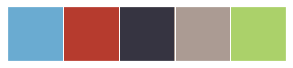

In [35]:
sns.palplot(pal)

In [37]:
hue_order = ["Healthy",
            "Lum A",
            "Lum B",
            "Her2",
            "Basal"]

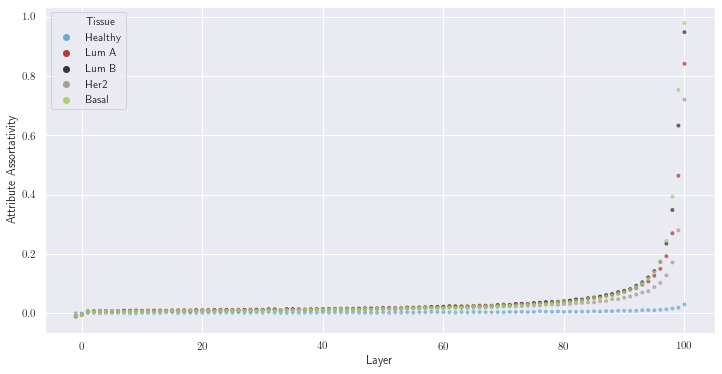

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(x=r'Layer', y=r'Attribute Assortativity',
                palette=pal,
                hue='Tissue',
                hue_order=hue_order,
                data=params_attr,
               edgecolor=None,
               s=10,
               alpha=0.7,
               ax=ax)
# ax.axhline(exp_val, color='k', linestyle='--')
fig.savefig(join(FIG, 'attribute_assortativity.png'), dpi=300)